In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString

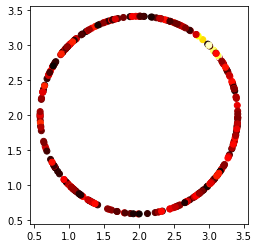

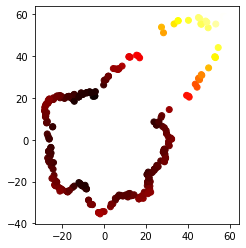

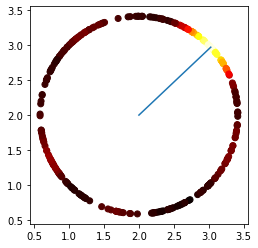

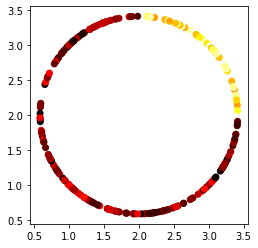

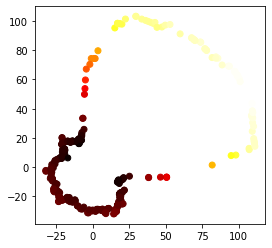

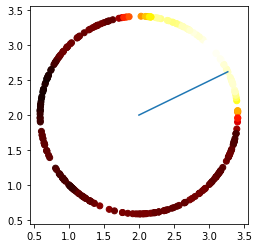

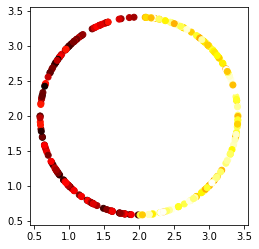

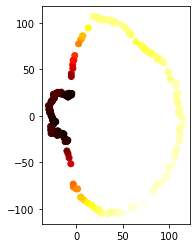

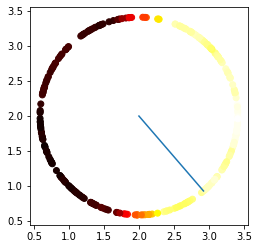

In [5]:
class direction_control():
    def __init__(self,coord,size_rand,step_size,mode=0,vis_bool=False,col_avg='average',neighbors=5,range_coord=[-1,1],range_val=[0,100],column=0,data_present = False):
        self.coord=coord
        self.x = coord[0]
        self.y = coord[1]
        self.size_rand=size_rand
        self.mode=mode
        self.sz = step_size
        self.vb = vis_bool
        self.col_avg = col_avg
        self.neighbors = neighbors
        self.rc1=range_coord[0]
        self.rc2=range_coord[1]
        self.rv1=range_val[0]
        self.rv2=range_val[1]
        self.column = column
        self.data_present = data_present

    def generate_data_random(self):
        l_x,l_y = np.random.uniform(self.rc1,self.rc2,self.size_rand),np.random.uniform(self.rc1,self.rc2,self.size_rand)
        l_z = np.random.uniform(self.rv1,self.rv2,self.size_rand)
        l_ratio = [(1/(a**2+ b**2))**0.5 for a,b in zip(l_x,l_y)]
        geometry = [Point(a*r, b*r) for a, b,r in zip(l_x, l_y,l_ratio)]
        gpd_data = gpd.GeoDataFrame(l_z,geometry=geometry)
        return(gpd_data)

    def generate_data(self):
        l_x,l_y = np.random.uniform(self.rc1,self.rc2,self.size_rand),np.random.uniform(self.rc1,self.rc2,self.size_rand)
        if self.mode==0:
            l_z = [np.random.uniform(self.rv1+60,self.rv2,1) if ((a>0.5)and(b>0.5))or((a>1)and(b>1)) else np.random.uniform(self.rv1,self.rv2-60,1) for a,b in zip(l_x,l_y)]
        elif self.mode==1:
            l_z = [np.random.uniform(self.rv1+60,self.rv2,1) if ((a>0)and(b>0))or((a>1)and(b>1)) else np.random.uniform(self.rv1,self.rv2-60,1) for a,b in zip(l_x,l_y)]
        elif self.mode==2:
            l_z = [np.random.uniform(self.rv1+60,self.rv2,1) if ((a>0)and(b>0))or((a>0)and(b<0)) else np.random.uniform(self.rv1,self.rv2-60,1) for a,b in zip(l_x,l_y)]
        l_ratio = [(self.sz/(a**2+ b**2))**0.5 for a,b in zip(l_x,l_y)]
        geometry = [Point(a*r +self.x, b*r+self.y) for a, b,r in zip(l_x, l_y,l_ratio)]
        gpd_data = gpd.GeoDataFrame(l_z,geometry=geometry)
        #gpd_data['x'] = gpd_data['geometry'].x
        return(gpd_data)

    def smallest_points(self):
        gpd_data = self.generate_data()
        lst_return = []
        for a,b in zip(gpd_data['geometry'].x,gpd_data['geometry'].y):
            gpd_dist = gpd_data.distance(Point(a,b))
            lst_return.append(gpd_dist.sort_values()[:self.neighbors].index.to_numpy())
        return(lst_return,gpd_data)

    def average_values(self):
        lst_sim,gpd_data = self.smallest_points()
        lst_return = []
        for row in lst_sim:
            lst_return.append(gpd_data.iloc[row][self.column].mean())
        gpd_data[self.col_avg] = lst_return
        return(gpd_data)

    def scale_circle(self):
        gpd_data = self.average_values()
        lst_norm_scale = []
        for a,b,r in zip(gpd_data['geometry'].x,gpd_data['geometry'].y,(gpd_data[self.col_avg])):
            lst_norm_scale.append(Point((a-self.x)*r,((b-self.y)*r)))
            
        gpd_data['geometry_old'] = gpd_data['geometry']
        gpd_data['geometry'] = lst_norm_scale
        
        point,_ = self.get_max_val(gpd_data)
        gpd_dist = gpd_data.distance(point)
        lst_ids = gpd_dist.sort_values()[:int(self.neighbors/2)].index.to_numpy()
        gpd_data_cut = gpd_data.iloc[lst_ids]

        if self.vb:#!=True:
            #self.visualize_data_in_circle_avg()
            gpd_data.plot(column = self.col_avg,cmap='hot')
            #plt.plot(np.unique(gpd_data_cut['geometry'].x), np.poly1d(np.polyfit(gpd_data_cut['geometry'].x, gpd_data_cut['geometry'].y, 1))(np.unique(gpd_data_cut['geometry'].x)))
            #self.vb = False

        return(gpd_data,gpd_data_cut)

    def generate_vector(self):
        gpd_data,gpd_data_cut = self.scale_circle()
        m,b = np.polyfit(gpd_data_cut['geometry'].x, gpd_data_cut['geometry'].y, 1)
        _,idx = self.get_max_val(gpd_data)
        coord_best = gpd_data.iloc[idx]['geometry_old']
        x_c = coord_best.x-self.x
        y_c = -x_c/m
        #calculate ratio
        r = (self.sz/(x_c**2+ y_c**2))**0.5
        vec = (x_c*r,y_c*r)

        if self.vb:
            #plt.plot([0,x_c*100],[0,y_c*100])
            gpd_data_copy = gpd_data.copy()

            #Vis 1
            gpd_data_copy['geometry'] = gpd_data_copy['geometry_old']
            self.visualize_data_in_circle_avg(gpd_data_copy)
            #plt.plot([0+self.x,vec[0]+self.x],[0+self.y,vec[1]+self.y])
            
            #Vis 2
            self.data_present = True
            max_coord, _ = self.get_max_val(gpd_data_copy)
            plt.plot([0+self.x,max_coord.x],[0+self.y,max_coord.y])
            self.vb = False



    def get_max_val(self,data):
        gpd_data = data
        max_id = gpd_data['average'].idxmax()
        ret = gpd_data.iloc[max_id]['geometry']
        return(ret,max_id)


    def max_vector(self):
        gpd_data = self.average_values()
        max_id = gpd_data['average'].idxmax()
        vec_x, vec_y = gpd_data.iloc[max_id]['geometry'].x-self.x,gpd_data.iloc[max_id]['geometry'].y-self.y
        print(vec_x,vec_y)

        if self.vb:
            self.visualize_data_in_circle_avg()
            self.vb = False

    def visualize_data_in_circle_avg(self,data = None):
        if  self.data_present:
            gpd_data = data
            self.data_present = False
        else:
            gpd_data = self.average_values()
        gpd_data.plot(column = self.col_avg,cmap='hot')
        return(gpd_data)

    def visualize_data_in_circle(self):
        gpd_data = self.generate_data()
        gpd_data.plot(column = self.column,cmap='hot')
        return(gpd_data)


dc = direction_control(coord=(2,2),mode=0,vis_bool=True,neighbors=20,size_rand=300,step_size=2)
dc.visualize_data_in_circle()
data = dc.generate_vector()
dc = direction_control(coord=(2,2),mode=1,vis_bool=True,neighbors=20,size_rand=300,step_size=2)
dc.visualize_data_in_circle()
data = dc.generate_vector()
dc = direction_control(coord=(2,2),mode=2,vis_bool=True,neighbors=20,size_rand=300,step_size=2)
dc.visualize_data_in_circle()
data = dc.generate_vector()

In [6]:
dc = direction_control(coord=(2,2),mode=1,vis_bool=True,neighbors=80,size_rand=300,step_size=2)
for _ in range(1):
    data = dc.expanded_vis()

AttributeError: 'direction_control' object has no attribute 'expanded_vis'

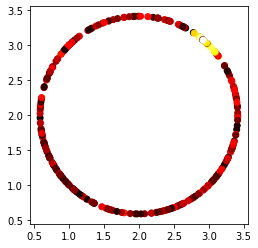

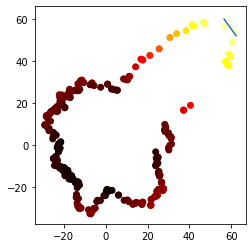

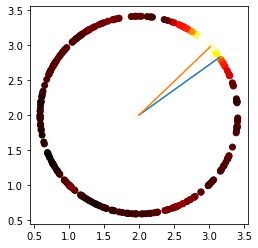

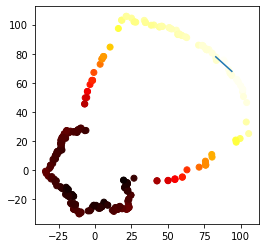

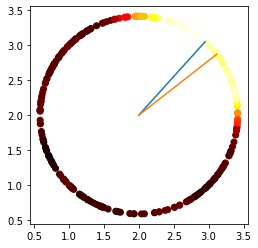

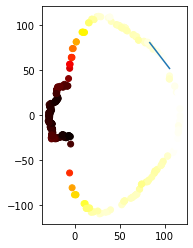

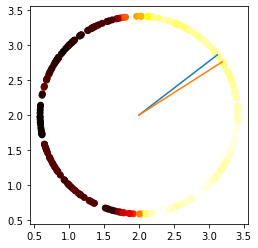

In [7]:
dc = direction_control(coord=(2,2),mode=0,vis_bool=True,neighbors=20,size_rand=300,step_size=2)
dc.visualize_data_in_circle()
data = dc.generate_vector()
dc = direction_control(coord=(2,2),mode=1,vis_bool=True,neighbors=20,size_rand=300,step_size=2)
data = dc.generate_vector()
dc = direction_control(coord=(2,2),mode=2,vis_bool=True,neighbors=20,size_rand=300,step_size=2)
data = dc.generate_vector()

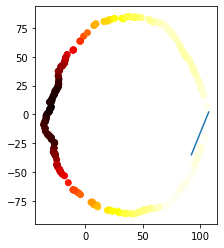

In [6]:
dc = direction_control(coord=(2,2),mode=2,vis_bool=True,neighbors=75,size_rand=300,step_size=2)
data = dc.expanded_vis()

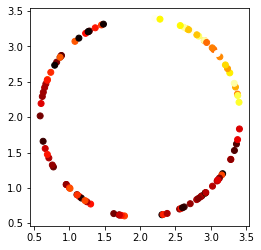

In [93]:
dc = direction_control(coord=(2,2),size_rand=100,step_size=2)
data = dc.visualize_data_in_circle()

In [1]:
c = 100
l_x = np.random.uniform(0,10,c)
l_y = np.random.uniform(0,10,c)
l_z = np.random.uniform(0,100,c)
geometry = [Point(a, b) for a, b in zip(l_x, l_y)]
gpd_data = gpd.GeoDataFrame(l_z,geometry=geometry)
#gpd_data['x'] = l_x
#gpd_data['y'] = l_y
#gpd_data['z'] = l_z
gpd_data.plot(column = 0,cmap='hot')

#print(gpd_data.plot())
#lt.scatter(l_x,l_y,l_z)
#random_points = [[x,y,z] for x,y,z in zip(l_x,l_y,l_z)];random_points=np.array(random_points)
#plt.scatter(random_points[:,0],random_points[:,1],random_points[:,2])

NameError: name 'np' is not defined

In [15]:
x=np.random.uniform(-1,1);y=np.random.uniform(-1,1)
r = 1/(x**2+ y**2)
print(x*r**.5,y*r**.5)
x,y,x**2+ y**2,r,(x*r**.5)**2+(y*r**.5)**2

-0.0306784034675518 -0.999529307004393


(-0.022161430712706487,
 -0.7220388605269583,
 0.5218312451223024,
 1.916328332860997,
 1.0)